In [721]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.getcwd() + '/../RKLM_Python/')
from data_assimilation import letkf

import importlib
importlib.reload(letkf)
%matplotlib inline

In [722]:
sigm = 10.
rho = 28.
beta = 8./3
dt = 0.001
Nout = int(50)
a = 1. / np.sqrt(dt)
fakt = 1.99999
N = int(2 * 10**5)

# initial conditions
x = -.587
y = -.563
z = 16.870
g1 = a * (1. / np.sqrt(2.) - .5)
g2 = a * (1. / np.sqrt(3.) - .5)
g3 = a * (1. / np.sqrt(5.) - .5)
res = np.zeros((N,7))

def gi(gi):
    if ((gi >= -a/2) and gi < 0):
        return a * (fakt * gi / a + 0.5)
    else:
        return a * (-fakt * gi / a + 0.5)
        
for i in range(N):
    res[i,:] = [i, x, y, z, g1, g2, g3]
    
    g1 = gi(g1)
    g2 = gi(g2)
    g3 = gi(g3)
    
    xn = x + dt * (sigm * (y - x)) + dt * g1
    yn = y + dt * (x * (rho - z) - y) + dt * g2
    zn = z + dt * (x * y - beta * z) + dt * g3
    
    x, y, z = xn, yn, zn
    
res[:,0] *= dt

# store only points with dt = 0.05
ressug = res[::Nout]

# add measurement error using tent map
meas = np.zeros((int(N)*4,2))
a = 4.
fakt = 1.99999
eta1 = a * (2.**(-1./2) - 0.5)

for i in range(N*4):
    if ((eta1 >= -a/2) and (eta1 < 0)):
        eta1 = (fakt * eta1 + 0.5 * a)
    else:
        eta1 = (-fakt * eta1 + 0.5 * a)
    meas[i] = [i+1, eta1]
    
measerr = meas[:,1][::10]

# observation of x-component (dt = 0.05, first 200 datapoints)
obsx = np.zeros((int(N/Nout),3))
j = 0
i = 0

for k in range(0,N,Nout):
    err = 1./20 * np.sum(measerr[j:j+20])
    obsx[i] = [res[k,0], res[k,1], err]
    i += 1
    j += 20
    
obsx = np.array(obsx)
obs = [obsx[:,0], obsx[:,1] + obsx[:,2]]
obs = np.array(obs)

In [723]:
def enkf_simple():
    None
    
# def forward_operator(X,R,M):
#     tmp = np.zeros_like(X.T)
#     print("tmp.shape = ", tmp.shape)
#     tmp[:,0] += np.sqrt(R) * np.random.randn(M)
#     print("tmp = ", tmp)
#     return lambda X : X + tmp

def forward_operator(X):
    return X[:,0]



In [724]:
STEPS = 5*40
R = 1./15

# recall that from example 4.8, the Lorenz model with drift term f(x) set to zero can be modelled 
# by a stochastic difference equation with mean = 0, var = 0.0838.
var = 0.0838

# sigma value given in example 6.9.
sigma = 0.1

NN = 20
m = np.arange(1,NN+1)
m = 2*m

#m = np.array([4])

rmse_x = np.zeros((NN))
rmse_y = np.zeros((NN))
rmse_z = np.zeros((NN))

for lkl in range(NN):
    M = m[lkl]
    
    x0 = -0.587
    y0 = -0.563
    z0 = 16.87
    
    x = x0 + np.sqrt(sigma) * np.random.randn(M)
    y = y0 + np.sqrt(sigma) * np.random.randn(M)
    z = z0 + np.sqrt(sigma) * np.random.randn(M)
    t= np.zeros((STEPS+1))
    
    x_f = np.zeros((STEPS+1))
    y_f = np.zeros((STEPS+1))
    z_f = np.zeros((STEPS+1))
    
    x_f[0] = np.mean(x)
    y_f[0] = np.mean(y)
    z_f[0] = np.mean(z)
    
    rmse_x[lkl] = 0.
    rmse_y[lkl] = 0.
    rmse_z[lkl] = 0.
    
    cnt = 0
    
    for j in range(STEPS):
        xh = x
        yh = y
        zh = z
        
        for i in range(Nout):
            xo = xh
            yo = yh
            zo = zh
            
            # step within each observation window by means of the stochastic Lorenz-63 model
            xh = xo + dt * 10. * (yo-xo) + np.sqrt(dt * var) * np.random.randn(M)
            yh = yo + dt * (xo * (28. - zo) - yo) + np.sqrt(dt * var) * np.random.randn(M)
            zh = zo + dt * (xo * yo - 8./3 * zo) + np.sqrt(dt * var) * np.random.randn(M)

        # Calculate residual: (forward map of reference - yobs)
        
        r = xh - obs[1,j+1]
        # Hz^f_i + eta_i - y_{obs} = rpert
        rpert = r + np.sqrt(R) * np.random.randn(M)
        
        x = xh
        y = yh
        z = zh
        
        X = np.vstack((x,y,z))
        
#         obs_current = obs[1,j+1] + np.sqrt(R) * np.random.randn(M)

#         obs_current = np.array([obs[1,j+1],0.,0.]).reshape(-1,1)
        obs_current = np.array([obs[1,j+1]]).reshape(-1,1)
    
        analysis = letkf.analysis(X.T)
        forward_op = forward_operator
#         forward_op = forward_operator(X,R,M)
        analysis.forward_operator = forward_op
#         R_sp = np.diag([np.inf] * len(obs_current))
#         R_sp = np.zeros_like(np.ones((len(obs_current),len(obs_current))))
#         R_sp[0,0] = R
        R_sp = np.array([R]).reshape(1,1)
#         R_sp = np.ones((len(obs_current),len(obs_current))) * R
        X = analysis.analyse(obs_current,R_sp).T
    
#         dX = X - np.mean(X, axis=1).reshape(-1,1)

#         P = dX[:,:,None] * dX.T[None,:,:]

#         P = P.sum(axis=1)/(M-1)
        
#         K = P[:,0] / (P[0,0] + R)
#         X -= np.outer(K,rpert)

        x = X[0,:]
        y = X[1,:]
        z = X[2,:]
        
        x_f[j+1] = np.mean(x)
        y_f[j+1] = np.mean(y)
        z_f[j+1] = np.mean(z)
        t[j+1] = dt * Nout * (j+1)
        
        rmse_x[lkl] = rmse_x[lkl] + (x_f[j+1] - ressug[j+1,1])**2
        rmse_y[lkl] = rmse_y[lkl] + (y_f[j+1] - ressug[j+1,2])**2
        rmse_z[lkl] = rmse_z[lkl] + (z_f[j+1] - ressug[j+1,3])**2
        
    rmse_x[lkl] = np.sqrt(rmse_x[lkl] / STEPS)
    rmse_y[lkl] = np.sqrt(rmse_y[lkl] / STEPS)
    rmse_z[lkl] = np.sqrt(rmse_z[lkl] / STEPS)


self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
se

self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
self.no_of_members =  2
self.Y.shape =  (2, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (2, 3)
se

obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.e

self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
self.no_of_members =  4
self.Y.shape =  (4, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (4, 3)
se

self.ensemble.shape =  (6, 3)
self.no_of_members =  6
self.Y.shape =  (6, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (6, 3)
self.no_of_members =  6
self.Y.shape =  (6, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (6, 3)
self.no_of_members =  6
self.Y.shape =  (6, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (6, 3)
self.no_of_members =  6
self.Y.shape =  (6, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (6, 3)
self.no_of_members =  6
self.Y.shape =  (6, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (6, 3)
self.no_of_members =  6
self.Y.shape =  (6, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (6, 3)
self.no_of_members =  6
self.Y.shape =  (6, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (6, 3)
self.no_of_members =  6
self.Y.shape =  (6, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (6, 3)
se

obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shap

self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
self.no_of_members =  8
self.Y.shape =  (8, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (8, 3)
se

self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (10, 3)
self.no_of_members =  10
self.Y.shape =  (10, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (12, 3)
self.no_of_members =  12
self.Y.shape =  (12, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (12, 3)
self.no_of_members =  12
self.Y.shape =  (12, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (12, 3)
self.no_of_members =  12
self.Y.shape =  (12, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (12, 3)
self.no_of_members =  12
self.Y.shape =  (12, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (12, 3)
self.no_of_members =  12
self.Y.shape =  (12, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (12, 3)
self.no_of_members =  12
self.Y.shape =  (12, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (12, 3)
self.no_of_members =  12
self.Y.shape =  (12, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (12, 3)
self.no_of_members =  12
self.Y.shape =  (12, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (14, 3)
self.no_of_members =  14
self.Y.shape =  (14, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (16, 3)
self.no_of_members =  16
self.Y.shape =  (16, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (18, 3)
self.no_of_members =  18
self.Y.shape =  (18, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (18, 3)
self.no_of_members =  18
self.Y.shape =  (18, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (18, 3)
self.no_of_members =  18
self.Y.shape =  (18, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (18, 3)
self.no_of_members =  18
self.Y.shape =  (18, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (18, 3)
self.no_of_members =  18
self.Y.shape =  (18, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (18, 3)
self.no_of_members =  18
self.Y.shape =  (18, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (18, 3)
self.no_of_members =  18
self.Y.shape =  (18, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (18, 3)
self.no_of_members =  18
self.Y.shape =  (18, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (20, 3)
self.no_of_members =  20
self.Y.shape =  (20, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (22, 3)
self.no_of_members =  22
self.Y.shape =  (22, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (22, 3)
self.no_of_members =  22
self.Y.shape =  (22, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (22, 3)
self.no_of_members =  22
self.Y.shape =  (22, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (22, 3)
self.no_of_members =  22
self.Y.shape =  (22, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (22, 3)
self.no_of_members =  22
self.Y.shape =  (22, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (22, 3)
self.no_of_members =  22
self.Y.shape =  (22, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (22, 3)
self.no_of_members =  22
self.Y.shape =  (22, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (22, 3)
self.no_of_members =  22
self.Y.shape =  (22, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (22, 3)
self.no_of_members =  22
self.Y.shape =  (22, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (22, 3)
self.no_of_members =  22
self.Y.shape =  (22, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (22, 3)
self.no_of_members =  22
self.Y.shape =  (22, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (24, 3)
self.no_of_members =  24
self.Y.shape =  (24, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (24, 3)
self.no_of_members =  24
self.Y.shape =  (24, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (24, 3)
self.no_of_members =  24
self.Y.shape =  (24, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (24, 3)
self.no_of_members =  24
self.Y.shape =  (24, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (24, 3)
self.no_of_members =  24
self.Y.shape =  (24, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (24, 3)
self.no_of_members =  24
self.Y.shape =  (24, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (24, 3)
self.no_of_members =  24
self.Y.shape =  (24, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (24, 3)
self.no_of_members =  24
self.Y.shape =  (24, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (24, 3)
self.no_of_members =  24
self.Y.shape =  (24, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (24, 3)
self.no_of_members =  24
self.Y.shape =  (24, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (24, 3)
self.no_of_members =  24
self.Y.shape =  (24, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (24, 3)
self.no_of_members =  24
self.Y.shape =  (24, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (24, 3)
self.no_of_members =  24
self.Y.shape =  (24, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (26, 3)
self.no_of_members =  26
self.Y.shape =  (26, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shap

self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (28, 3)
self.no_of_members =  28
self.Y.shape =  (28, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (30, 3)
self.no_of_members =  30
self.Y.shape =  (30, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (32, 3)
self.no_of_members =  32
self.Y.shape =  (32, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (34, 3)
self.no_of_members =  34
self.Y.shape =  (34, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shap

self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_of_members =  36
self.Y.shape =  (36, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (36, 3)
self.no_

self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (38, 3)
self.no_of_members =  38
self.Y.shape =  (38, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ens

self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)
self.ensemble.shape =  (40, 3)
self.no_of_members =  40
self.Y.shape =  (40, 1)
obs.shape =  (1,)
obs_covar.shape =  (1, 1)


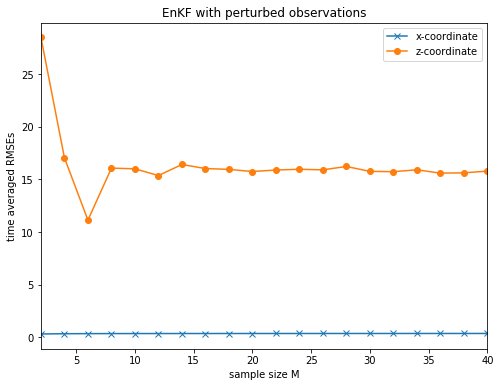

In [725]:
fig0a = plt.figure(figsize=(8,6))
plt.plot(m,rmse_x, 'x-', label="x-coordinate")
plt.plot(m,rmse_z, 'o-', label="z-coordinate")
plt.xlim([2,40])
# plt.ylim([0,0.6])
plt.xlabel("sample size M")
plt.ylabel("time averaged RMSEs")
plt.title("EnKF with perturbed observations")
plt.legend()
plt.show()